# Summarial Data Analysis

In [52]:
import pandas as pd
import numpy as np
import os
import sys

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

#plt.rcParams['text.usetex'] = True


To download the dataset, use or adapt the following:

In [ ]:
import subprocess

current_directory = os.getcwd()

# Define the scp command
scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-fulldat-first100.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-full-dataset.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

Note that the full dataset is around 6.5 GB.

TODO: Host dataset somewhere accessible publicly.

## Reading the full RaCA dataset into memory

You can use the first 100 entries if you prefer to keep your workflow memory-light for test purposes:

In [133]:
current_directory = os.getcwd()
joined = pd.read_csv(f"{current_directory}/data_utils/RaCA-fulldat-first100.csv")

Otherwise, import the full dataset as follows:

In [134]:
current_directory = os.getcwd()
joined = pd.read_csv(f"{current_directory}/data_utils/RaCA-full-dataset.csv")

## Understanding SOC estimates

First, before implementing selection cuts, let's understand how many datapoints we have and what they signify.

In [22]:
print("Total nonzero TC entries:",((full['c_tot_ncs'] != 0).astype(int)).sum())
print("Total nonnegative TC entries:",((full['c_tot_ncs'] >= 0).astype(int)).sum())
print("Total negative TC entries:",((full['c_tot_ncs'] <= 0).astype(int)).sum())
print()
print("Total nonzero SOC entries:",((full['soc'] != 0).astype(int)).sum())
print("Total nonnegative SOC entries:",((full['soc'] >= 0).astype(int)).sum())
print("Total negative SOC entries:",((full['soc'] < 0).astype(int)).sum())
print()
print("TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.")
print("Total nonzero carbonate entries:",((full['caco3'] != 0).astype(int)).sum())
print("Total nonnegative carbonate entries:",((full['caco3'] >= 0).astype(int)).sum())
print("Total negative carbonate entries:",((full['caco3'] < 0).astype(int)).sum())

Total nonzero TC entries: 352850
Total nonnegative TC entries: 80878
Total negative TC entries: 0

Total nonzero SOC entries: 351930
Total nonnegative SOC entries: 352850
Total negative SOC entries: 0

TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.
Total nonzero carbonate entries: 352850
Total nonnegative carbonate entries: 42406
Total negative carbonate entries: 1458


The takeaway from the above is that:
- We have 80,878 analyses of total carbon
- We have only 43,406 analyses of calcite content
- Thus, the maximum number of direct SOC estimates we can make from TC - CO3 is 43,406
- We have more analyses of SOC than total carbon
- Thus, SOC estimates are not coming from laboratory estimates
- SoilDB documentation indicates these SOC values are modeled from the spectral data

The immediate next questions are:
- How many of the SOC values are not modeled?
- When a direct SOC estimate is available, is that reflected as TC - CO3 in some way?

## Implementing selection cuts

If ADOD is the ratio of air-dried mass to oven-dried mass, then ADOD > 1 and the mass percentage of water in the air-dried sample is 1 - 1/ADOD.

If ADOD is too high, then there is a chance that the sample was not fully or properly air-dried before the VNIR scan data was collected. The possibility of this happening is reflected in the RaCA documentation: sample collection teams were originally permitted to collect both air-dried and field-moist samples. It is possible that this is noted somewhere in soilDB (TODO: check with admins), but it is not documented how to distinguish between spectra for identical samples where one is air-dried and one is field-moist. This means that spectral features associated to water in liquid phase could contaminate the data. As such, we should at minimum discard samples where ADOD is above some threshold. Here, we analyze this selection cut in detail. 

In [135]:
print("Total nonnegative TC: ",((full['c_tot_ncs'] > 0).astype(int)).sum())
print(((full['c_tot_ncs'] > 0).astype(int) * (full['500'] > 0).astype(int)).sum())
print(((full['c_tot_ncs'] > 0).astype(int) * (full['500'] > 0).astype(int) * (full['adod'] > 0).astype(int)).sum())
print(((full['c_tot_ncs'] > 0).astype(int) * (full['500'] > 0).astype(int) * (full['adod'] > 0).astype(int) * ((1-1/full['adod']) < 0.2).astype(int)).sum())

Total nonnegative TC:  80878
80878
80773
80760


(array([ 1.,  3.,  1.,  4.,  1.,  4.,  5.,  9., 12.,  5.]),
 array([1.0067419 , 1.01664706, 1.02655221, 1.03645737, 1.04636252,
        1.05626768, 1.06617283, 1.07607799, 1.08598314, 1.0958883 ,
        1.10579345]),
 <BarContainer object of 10 artists>)

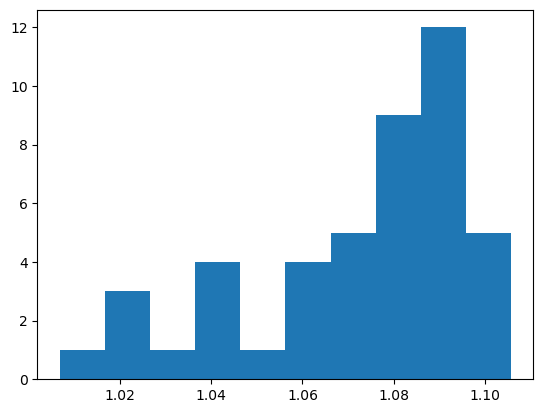

In [13]:
from matplotlib import pyplot as plt    
plt.hist(joined['adod'])

(array([1.2041e+04, 2.1237e+04, 1.5887e+04, 9.7400e+03, 5.3560e+03,
        3.2940e+03, 2.6360e+03, 2.3510e+03, 2.2860e+03, 1.9670e+03,
        1.2840e+03, 1.0480e+03, 6.0100e+02, 4.7400e+02, 2.6100e+02,
        1.5500e+02, 1.0500e+02, 3.6000e+01, 1.4000e+01, 1.9000e+01,
        6.0000e+00, 4.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([2.61141787e-04, 9.86904334e-03, 1.94769449e-02, 2.90848464e-02,
        3.86927480e-02, 4.83006495e-02, 5.79085511e-02, 6.75164526e-02,
        7.71243542e-02, 8.67322557e-02, 9.63401573e-02, 1.05948059e-01,
        1.15555960e-01, 1.25163862e-01, 1.34771763e-01, 1.44379665e-01,
        1.53987567e-01, 1.6359

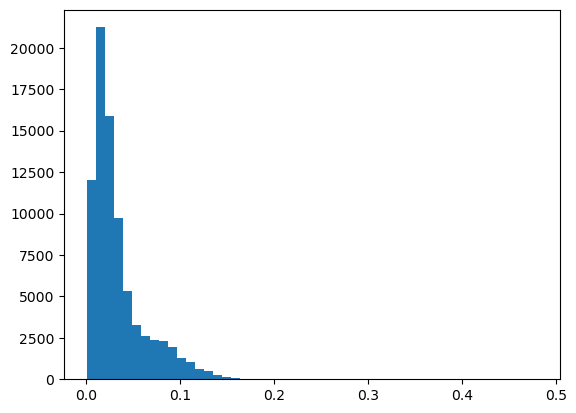

In [70]:
plt.hist(1 - 1/full['adod'],bins=50)

In [24]:
(joined['soc_measured'] > 0).astype(int).sum()

TypeError: '>' not supported between instances of 'str' and 'int'

In [26]:
joined['soc']

0     10.232516
1     10.232516
2     10.232516
3     10.232516
4      2.438914
        ...    
94     1.389788
95     1.389788
96    10.096485
97    10.096485
98    10.096485
Name: soc, Length: 99, dtype: float64

## Plotting SOC spectral data $f_{SOC}(\lambda)$

Here is some sample code to generate nice plots of posterior distributions of $f_{SOC}(\lambda)$.

Immediately below are a list of wavelengths associated to spectral absorption by organic functional groups, as well as some helper variables.

In [57]:
organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]
MSpectra = 2151
NTest = 100
XF = np.array([x for x in range(350,2501)]);

Here we generate 100 fake seed spectra at random:

In [120]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

tFsoc = np.ones([NTest,MSpectra])*0.8
seedFsoc = tFsoc - 0.5*(np.random.randn(NTest,1)*0.6 + 0.3) *np.sum(fakeTrough((np.ones([1,MSpectra])*XF).T,np.array(organicTroughs),1000*gaus(1.0,0.35,len(organicTroughs))).T,axis=0)

Now we plot the reflectance quantiles:

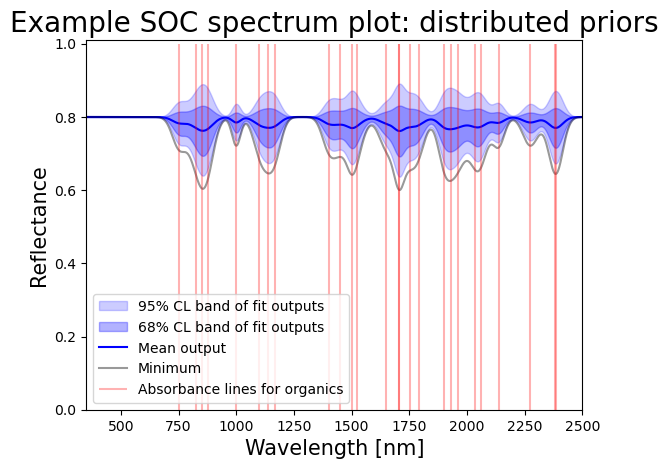

In [122]:
# Plot quantiles
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=0),np.quantile(socspecs,0.005,axis=0),color='blue',alpha=0.1,label=r'99\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(seedFsoc,0.975,axis=0),np.quantile(seedFsoc,0.025,axis=0),color='blue',alpha=0.2,label=r'95% CL band of fit outputs')
plt.fill_between(XF,np.quantile(seedFsoc,0.84,axis=0),np.quantile(seedFsoc,0.16,axis=0),color='blue',alpha=0.3,label=r'68% CL band of fit outputs')

# Plot means and mins
plt.plot(XF,np.mean(seedFsoc,axis=0), color='blue', label=r'Mean output');
plt.plot(XF,np.min(seedFsoc,axis=0), color='black',alpha=0.4, label=r'Minimum');

# Style plot
plt.xlim([350.0,2500.0])
plt.ylim([0.0,1.01])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Example SOC spectrum plot: distributed priors',fontsize=20)

# Add absorbance lines for organics
plt.vlines(organicTroughs,ymin=0.0,ymax=1.0, color='red', alpha=0.3, label="Absorbance lines for organics")

# Add legend
plt.legend(loc='best');

## Plotting geographic data 

The pandas dataframe has a column called 'y' and 'x' which are latitudes and longitudes, respectively.

Here we make an example histogram plot of the density of the samples overlaid on a map of the United States.

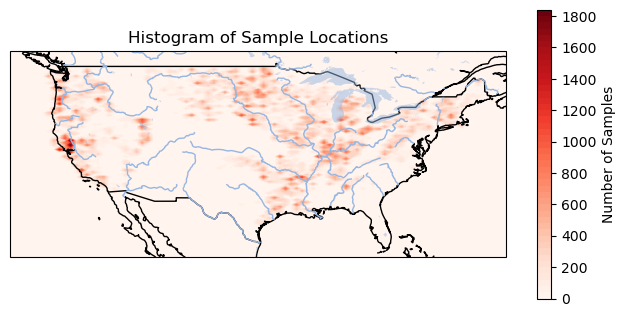

In [161]:
# Create a figure
fig = plt.figure(figsize=(8, 15))

# Create a GeoAxes in the figure
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
#ax.add_feature(cfeature.LAND, facecolor='0')
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add a latitude and longitude grid
#ax.gridlines(draw_labels=True)

# Overlay heatmap of number of samples for each 1x1 degree grid cell
# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(full['x'], full['y'], bins=90, range=[[-130, -65], [24, 51]])
# Plot the histogram2d
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Reds', vmin=1)
# Perform kerning on the heatmap
plt.gcf().gca().update_datalim(np.column_stack([full['x'], full['y']]))
# Make a contour plot of the heatmap
plt.contourf(xedges[:-1], yedges[:-1], hist.T, 50, cmap='Reds')

# Add a log colorbar
plt.colorbar(label='Number of Samples', shrink=0.25, pad=0.05, norm=LogNorm())

# Add a title
plt.title('Histogram of Sample Locations')

# Restrict to the continental United States
ax.set_extent([-130, -65, 24, 51])
plt.ylim(24,51)

# Show the plot
plt.show()
